In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv ('Data/weekly_features.csv')
df = df.drop (columns = ['Unnamed: 0','USD_PHP Historical Data.csv'])
dates = df.year*100+df.week
df['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
mask = (df['Date'] >'1990-09-30') & (df['Date'] <= '2021-09-30')
df= df.loc[mask]
df = df.fillna(method='ffill')

In [3]:
def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.to_datetime().timetuple())

In [4]:
# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
# difference dataset
diff_df=df.drop(columns=['Date', 'year', 'week'])
diff_df = diff_df.diff()
diff_df = diff_df.iloc[1:]
#diff_df['year']=df.year[1:]
#diff_df['week']=df.year[1:]
diff_df['Date']=df.Date[1:]
diff_df['Date'] = pd.to_datetime(diff_df['Date'])
# convert date to timestamp
diff_df['Date'] = diff_df['Date'].map(pd.Timestamp.timestamp)

In [5]:
#split the data into training and testing dataset
column_indices = {name: i for i, name in enumerate(diff_df.columns)}

n = len(diff_df)
train_df = diff_df[0:int(n*0.7)]
val_df = diff_df[int(n*0.7):int(n*0.9)]
test_df = diff_df[int(n*0.9):]

num_features = diff_df.shape[1]

In [6]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
#col_list = [i for i in diff_df.columns if i != 'Date']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_val = scaler.transform(val_df)
scaled_test = scaler.transform(test_df)

In [61]:
train_df

,tmax,tmin,prcp,Crude Oil WTI,Gold,Oats,Corn,Soybeans,Wheat,USD_CAD,USD_CNY,USD_EUR,USD_MXN,SWE,SNOW,SNWD,Date
0,0.512428,0.446089,0.254001,0.401423,0.487986,0.473610,0.582695,0.566839,0.464385,0.625731,0.033587,0.447679,0.374121,0.714737,0.576833,0.539603,0.000000
1,0.403599,0.407601,0.503039,0.290277,0.589355,0.488690,0.624043,0.600961,0.512086,0.533087,0.033587,0.523412,0.374939,0.728241,0.560569,0.524908,0.000885
2,0.589891,0.554087,0.311203,0.650672,0.602532,0.449576,0.605666,0.565969,0.509305,0.470760,0.033587,0.523819,0.372486,0.753975,0.892940,0.537638,0.001770
3,0.158053,0.342399,0.798439,0.478103,0.606063,0.467955,0.616896,0.567710,0.524706,0.500769,0.033587,0.409609,0.372486,0.799849,1.000000,0.590455,0.002655
4,0.707618,0.565477,0.125489,0.415099,0.559211,0.388313,0.586524,0.565795,0.469091,0.490920,0.033587,0.474959,0.373304,0.830503,0.557208,0.517865,0.003540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.462703,0.424069,0.456411,0.256680,0.368185,0.454760,0.539306,0.470909,0.406809,0.583410,0.034335,0.645358,0.541837,0.113295,0.573318,0.492359,0.996460
1145,0.668366,0.599534,0.398735,0.359051,0.408750,0.500943,0.487749,0.490582,0.625348,0.603724,0.037969,0.657166,0.520837,0.027967,0.573151,0.499445,0.997345
1146,0.522675,0.623708,0.491287,0.433360,0.593489,0.333648,0.513017,0.547289,0.727308,0.585411,0.037514,0.602199,0.426062,0.073761,0.574266,0.501499,0.998230
1147,0.496521,0.520449,0.623413,0.352213,0.602769,0.085768,0.401417,0.524129,0.337947,0.548169,0.041268,0.643730,0.457247,0.164924,0.573941,0.512872,0.999115


#### Turn the numpy array to dataframe

In [7]:
train_df = pd.DataFrame(data = scaled_train, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])
val_df = pd.DataFrame(data = scaled_val, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])
test_df = pd.DataFrame(data = scaled_test, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])

#### Turn the dataset into a series of smaller dataset, which is the so called window

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df,val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    # from total window, slice a part as input
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    # from total window, slice a part as output
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### Split window into input and label

In [9]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def split_sequence(self, data):
    inputs, labels = list(), list()
    data = np.array(data, dtype=np.float32)
    for i in range(len(data)): 
        lag_end = i + input_width
        forecast_end = lag_end + label_width
        if forecast_end > len(data):
            break
    seq_x, seq_y = data[i:lag_end], data[lag_end:forecast_end]
    inputs.append(seq_x)
    labels.append(seq_y)
    return np.array(inputs), np.array(labels)

WindowGenerator.split_sequence = split_sequence

### Generate tf dataset
#### This step take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs

In [11]:
# The make dataset function would generate the required batches with each sample have inputs and labels. 
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    print(data.shape)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

#### Let the training and testing dataset hold by the WindowGenerator to turn them into tf.data.Dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)
@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Fit dataset

In [13]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    min_delta=0.005,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, 
                        validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [14]:
def plot(self, model=None, plot_col='Wheat', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### Set the window

In [15]:
OUT_STEPS = 10
n_timesteps = 10
input_width =50
# shift is how many steps after the last input 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=n_timesteps,
                               shift=OUT_STEPS,
                              label_columns = ['Wheat'])

# Model 

### Baseline

(1149, 17)
35/35 [==============================] - 1s 8ms/step - loss: 0.0401 - mean_absolute_error: 0.1433
(165, 17)
(1149, 17)


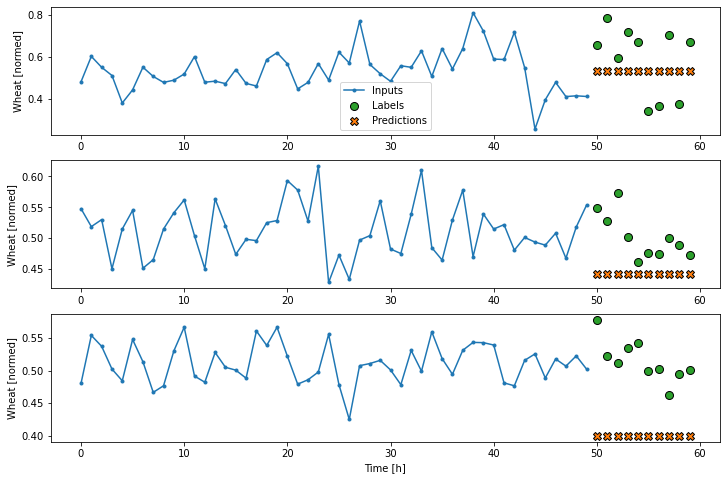

In [16]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_train_performance = {}
multi_performance = {}

multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

### CNN-LSTM Encoder-Decoder Model

In [17]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(input_width, num_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(OUT_STEPS))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(num_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

(1149, 17)
35/35 [==============================] - 1s 25ms/step - loss: 0.0065 - mean_absolute_error: 0.0537
(165, 17)


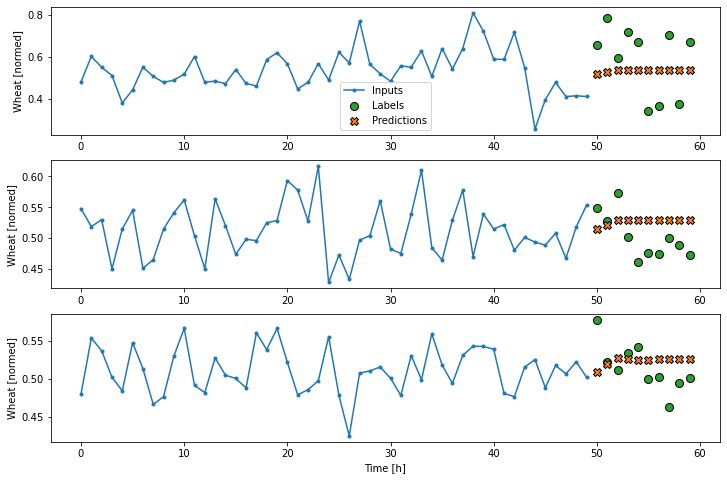

In [18]:
history = compile_and_fit(model_enc_dec_cnn, multi_window)

IPython.display.clear_output()

multi_train_performance['CNN-LSTM'] = model_enc_dec_cnn.evaluate(multi_window.train)
multi_performance['CNN-LSTM'] = model_enc_dec_cnn.evaluate(multi_window.test, verbose=0)
multi_window.plot(model_enc_dec_cnn)

#### LSTM

(1149, 17)
35/35 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0532
(165, 17)


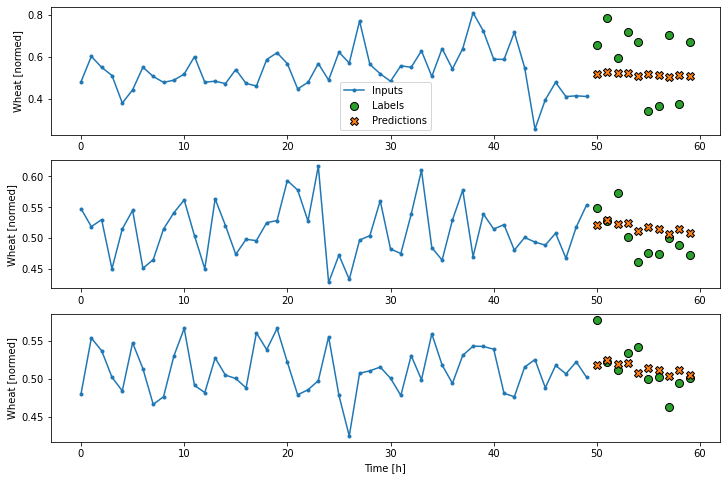

In [19]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
def CNN_LSTM_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [ ]:
cnn_lstm = CNN_LSTM_model()

### CNN-LSTM ecoder decoder model

In [17]:
# univariate multi-step encoder-decoder cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [20]:
multi_train_performance = {}

In [107]:
OUT_STEPS = 24
n_timesteps = 10
multi_window = WindowGenerator(input_width=24,
                               label_width=n_timesteps,
                               shift=OUT_STEPS)

In [108]:
multi_window.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 17), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 17), dtype=tf.float32, name=None))>

35/35 [==============================] - 1s 30ms/step - loss: 269329.8750 - mean_absolute_error: 231.8310


InvalidArgumentError: slice index 10 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

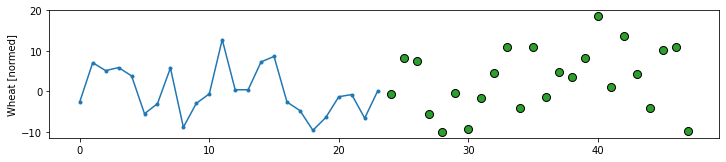

In [55]:
cnn_lstm_model = CNN_LSTM_model()
history = compile_and_fit(cnn_lstm_model, multi_window)

IPython.display.clear_output()
multi_train_performance['CNN-LSTM'] = cnn_lstm_model.evaluate(multi_window.train)
#multi_performance['CNN-LSTM'] = cnn_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(cnn_lstm_model)

In [58]:
predictions = cnn_lstm_model(inputs)
predictions

<tf.Tensor: shape=(32, 24, 1), dtype=float32, numpy=
array([[[ 1.15580605e+02],
        [ 1.17343292e+02],
        [ 1.09960968e+02],
        [ 6.61699524e+01],
        [ 9.70617676e+01],
        [ 7.94196472e+01],
        [ 7.32427979e+01],
        [ 6.33269348e+01],
        [ 6.78108215e+01],
        [ 7.03301697e+01],
        [ 6.40419617e+01],
        [ 4.01427917e+01],
        [ 3.87319031e+01],
        [ 4.35998230e+01],
        [ 4.71711121e+01],
        [ 3.95785828e+01],
        [ 4.81081238e+01],
        [ 6.91647644e+01],
        [ 7.40385437e+01],
        [ 7.37958679e+01],
        [ 7.19003601e+01],
        [ 6.91225281e+01],
        [ 6.49706726e+01],
        [ 5.63451843e+01]],

       [[ 1.62727432e+02],
        [ 1.40003540e+02],
        [ 1.10437164e+02],
        [ 1.10472565e+02],
        [ 1.12572693e+02],
        [ 1.33347946e+02],
        [ 1.36593781e+02],
        [ 1.08555847e+02],
        [ 1.16887726e+02],
        [ 9.48471985e+01],
        [ 7.13527527e+01],


In [60]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_conv_model(multi_window.example[0]).shape)

Input shape: (32, 24, 18)
Output shape: (32, 24, 18)


In [61]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', cnn_lstm_model(multi_window.example[0]).shape)

Input shape: (32, 24, 18)
Output shape: (32, 24, 1)


In [56]:
inputs, labels = multi_window.example

In [52]:
# train the model
def CNN_LSTM_model():
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,num_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(OUT_STEPS))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    return model

In [18]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),

    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
#multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

NameError: name 'OUT_STEPS' is not defined

35/35 [==============================] - 1s 6ms/step - loss: 0.7349 - mean_absolute_error: 0.5049


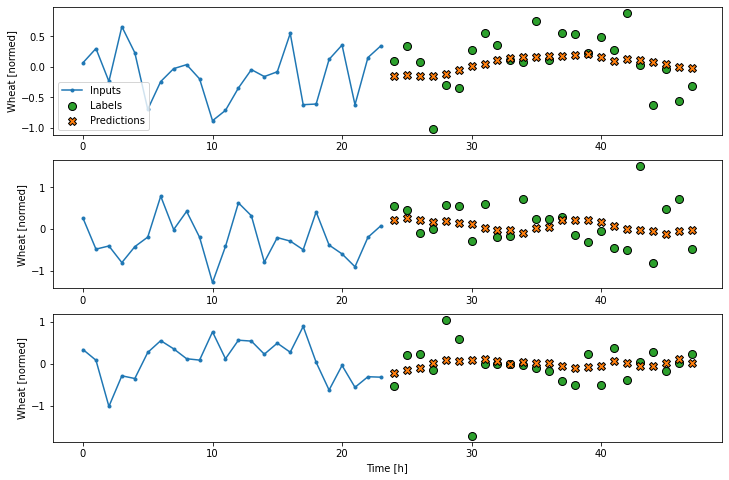

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
#multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)